<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
# Instalamos nuestro paquete
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [232]:
!pip uninstall nlptweet

Uninstalling nlptweet-0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/nlp/*
    /usr/local/lib/python3.7/dist-packages/nlptweet-0.1.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled nlptweet-0.1


In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
#import re
import timeit
import string
# Nuestro paquete
import nlp


#call the nltk downloader
nltk.download('punkt')

from dateutil import parser

from sklearn.model_selection import train_test_split

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [223]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweet

# Carga y limpieza de datos

In [3]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv
Saving testdata.manual.2009.06.14.csv to testdata.manual.2009.06.14.csv


In [250]:
training = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', names=col_names)

In [251]:
test = pd.read_csv('testdata.manual.2009.06.14.csv', names=col_names)

In [252]:
print(training.shape)
print(test.shape)

(1600000, 6)
(498, 6)


In [253]:
training.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [254]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de entrenamiento\n", training.isna().sum())

Revisamos si hay valores nulos en el set de entrenamiento
 target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


In [255]:
# Revisamos si tenemos valores nulos.
print("Revisamos si hay valores nulos en el set de pruebas\n", test.isna().sum())

Revisamos si hay valores nulos en el set de pruebas
 target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


## Convertimos a minúsculas

In [256]:
from nlp.preprocessing import convierte_a_minusculas

In [257]:
training = nlp.preprocessing.convierte_a_minusculas(training)
test = nlp.preprocessing.convierte_a_minusculas(test)

## Reemplazamos las URLs con el texto "URL"

In [258]:
from nlp.preprocessing import reemplazar_urls

In [259]:
#The regular expression used to match URLs is ((www\.[\S]+)|(https?://[\S]+)).

def reemplazar_urls(phrase):
  return re.sub("((www\.[\S]+)|(https?://[\S]+))", "url", phrase)

In [260]:
training['text'] = training['text'].map(lambda s: reemplazar_urls(s))
test['text'] = test['text'].map(lambda s: reemplazar_urls(s))

## Reemplazamos las menciones @ con la palabra "USER_MENTION"



In [261]:
# The regular expression (regex) used to match user mention is @[\S]+. 2.

In [262]:
from nlp.preprocessing import reemplazar_usuarios

In [263]:
def reemplazar_usuarios(phrase):
  return re.sub("@[\S]+", "user_mention", phrase)

In [264]:
training['text'] = training['text'].map(lambda s: reemplazar_usuarios(s))
test['text'] = test['text'].map(lambda s: reemplazar_usuarios(s))

## Quitamos el Hashtag , pero dejamos la palabra

In [265]:
# The regular expression used to match hashtags is #(\S+).

In [266]:
def quitar_hashtag(phrase):
  return re.sub("#(\S+)", "", phrase)

In [267]:
training['text'] = training['text'].map(lambda s: quitar_hashtag(s))
test['text'] = test['text'].map(lambda s: quitar_hashtag(s))

## Quitamos los Retweets, sólo la palabra RT , dejamos el comentario

In [268]:
#  The regular expression used to match retweets is \brt\b.

In [269]:
def quitar_RT(phrase):
  return re.sub("\brt\b", "", phrase)

In [270]:
training['text'] = training['text'].map(lambda s: quitar_RT(s))
test['text'] = test['text'].map(lambda s: quitar_RT(s))

## Quitamos espacios o puntos extras

In [271]:
## Reemplazamos los dobles puntos (o más) con un espacio , dos o más espacios con 1 espacio y hacemos strip de espacios y comillas
# Strip any punctuation [’"?!,.():;-'] from the word ??

In [272]:
from nlp.preprocessing import quitar_caracteres_especiales

In [273]:
def quitar_caracteres_especiales(phrase):
  caracteres_especiales = '’"?!,.():;-'
  # quita dobles espacios y lo hace 1
  phrase = re.sub(' +', ' ', phrase)
  # quita los caracteres especiales
  regex = re.compile('[%s]' % re.escape(caracteres_especiales))

  return regex.sub('', phrase)

In [274]:
training['text'] = training['text'].map(lambda s: quitar_caracteres_especiales(s))
test['text'] = test['text'].map(lambda s: quitar_caracteres_especiales(s))

## Quitamos expresiones con letras repetidas

In [275]:
#Convert 2 or more letter repetitions to 2 letters.
#Some people send tweets like I am sooooo
#happpppy adding multiple characters to emphasize
#on certain words. This is done to handle such tweets
#by converting them to I am soo happy

In [276]:
def quitar_letras_repetidas(phrase):
  return re.sub(r'(.)\1+', r'\1\1', phrase)

In [277]:
training['text'] = training['text'].map(lambda s: quitar_letras_repetidas(s))
test['text'] = test['text'].map(lambda s: quitar_letras_repetidas(s))

## Quitar caracteres nonascii

In [278]:
def quitar_nonascii(phrase):
  return phrase.encode('ascii', errors='ignore').decode('utf-8')

In [279]:
training['text'] = training['text'].map(lambda s: quitar_nonascii(s))
test['text'] = test['text'].map(lambda s: quitar_nonascii(s))

## Removemos stopwords

In [280]:
nltk.download('stopwords') # Use predefined list of stopwords from nltk

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [281]:
# Aux funcción para substituir abreviaciones
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [282]:
training['text'] = training['text'].map(lambda s: decontracted(s))
test['text'] = test['text'].map(lambda s: decontracted(s))

In [283]:
# Set adicional de stopwords, removeremos palabras tanto de este set como del que
# viene definido en el nltk
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [284]:
# Función auxiliar para remover stopwords y otras estandarizaciones de texto
# (Aqui puedes incluir el lematizador o stemming si gustas explorarlos)
def remove_stopwords(phrase):
    phrase = ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords)
    phrase = ' '.join(e.lower() for e in phrase.split() if e.lower() not in STOPWORDS)
    return phrase

In [285]:
training['text'] = training['text'].map(lambda s: remove_stopwords(s))
test['atext'] = test['text'].map(lambda s: remove_stopwords(s))

In [286]:
training

,target,ids,date,flag,user,text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,user_mention url aww bummer shoulda got david ...
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset update facebook texting might cry result...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,user_mention dived many times ball managed sav...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole body feels itchy like fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,user_mention behaving mad see
...,...,...,...,...,...,...
1599995,4,2193601966,tue jun 16 08:40:49 pdt 2009,no_query,amandamarie1028,woke school best feeling ever
1599996,4,2193601969,tue jun 16 08:40:49 pdt 2009,no_query,thewdboards,thewdbcom cool hear old walt interviews url
1599997,4,2193601991,tue jun 16 08:40:49 pdt 2009,no_query,bpbabe,ready mojo makeover ask details
1599998,4,2193602064,tue jun 16 08:40:49 pdt 2009,no_query,tinydiamondz,happy 38th birthday boo time tupac amaru shakur


## Stemming con NLTK

In [287]:

#create an object of class PorterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [288]:
training['text'] = training['text'].map(lambda s: stemSentence(s))
test['atext'] = test['text'].map(lambda s: stemSentence(s))

In [289]:
training

,target,ids,date,flag,user,text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,user_ment url aww bummer shoulda got david car...
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,upset updat facebook text might cri result sch...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,user_ment dive mani time ball manag save 50 % ...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,whole bodi feel itchi like fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,user_ment behav mad see
...,...,...,...,...,...,...
1599995,4,2193601966,tue jun 16 08:40:49 pdt 2009,no_query,amandamarie1028,woke school best feel ever
1599996,4,2193601969,tue jun 16 08:40:49 pdt 2009,no_query,thewdboards,thewdbcom cool hear old walt interview url
1599997,4,2193601991,tue jun 16 08:40:49 pdt 2009,no_query,bpbabe,readi mojo makeov ask detail
1599998,4,2193602064,tue jun 16 08:40:49 pdt 2009,no_query,tinydiamondz,happi 38th birthday boo time tupac amaru shakur


In [290]:
training.target.unique()

array([0, 4])

Quitamos datos al entrenamiento, empecemos con 100,000 

In [291]:
data_set_1 = training.head(50000)
data_set_1 = pd.concat([data_set_1, training.tail(50000)])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


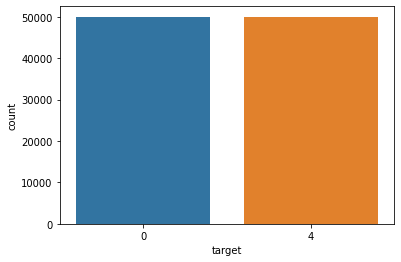

In [292]:
# Revisamos si estan balanceadas las etiquetas
import seaborn as sns
sns.countplot(data_set_1['target'])

# Entrenamos un Tokenizer

In [302]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

# Entrena un Tokenizer. Consiste en:
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las N palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario (NOT USED HERE)


max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_set_1.text)
sequences = tokenizer.texts_to_sequences(data_set_1.text)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  967 1658    5]
 [   0    0    0 ...   12  187 1078]
 [   0    0    0 ...  335    3 2755]
 ...
 [   0    0    0 ...  137  308 1584]
 [   0    0    0 ...  203  306   13]
 [   0    0    0 ...    1    2    1]]


## Separamos en train, test

In [303]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data_set_1.target.values, test_size=0.3, random_state=23042021)

In [304]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (70000, 200)
y_train (70000,)
X_test (30000, 200)
y_test (30000,)


# Creamos el modelo

In [313]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l1

## De la clase

In [298]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=128, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=82, activation='relu'))
model.add(Dense(units=1, activation=None))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 128, 64)           64000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 82)               

In [299]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [300]:
%%timeit

# Train it
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)# validation_data=(x_val, y_val))

Epoch 1/10
3500/3500 [==============================] - 326s 93ms/step - loss: -11294152099.1134 - binary_accuracy: 0.0104 - accuracy: 0.0104 - val_loss: -238862073856.0000 - val_binary_accuracy: 0.0235 - val_accuracy: 0.0235
Epoch 2/10
3500/3500 [==============================] - 326s 93ms/step - loss: -542006104657.1654 - binary_accuracy: 0.0358 - accuracy: 0.0358 - val_loss: -2224615325696.0000 - val_binary_accuracy: 0.0661 - val_accuracy: 0.0661
Epoch 3/10
3500/3500 [==============================] - 332s 95ms/step - loss: -3295855439269.4751 - binary_accuracy: 0.0486 - accuracy: 0.0486 - val_loss: -7963646361600.0000 - val_binary_accuracy: 0.0143 - val_accuracy: 0.0143
Epoch 4/10
3500/3500 [==============================] - 326s 93ms/step - loss: -10516443088125.5879 - binary_accuracy: 0.0552 - accuracy: 0.0552 - val_loss: -20029548527616.0000 - val_binary_accuracy: 0.0376 - val_accuracy: 0.0376
Epoch 5/10
3500/3500 [==============================] - 328s 94ms/step - loss: -245449

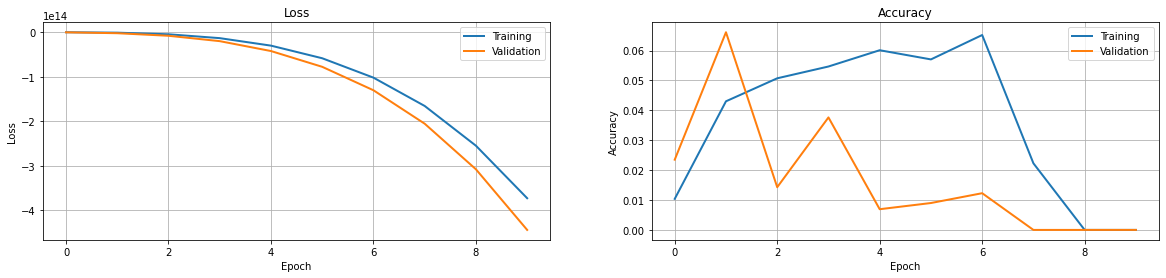

In [301]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_binary_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

### RNN, tomado de: https://www.kaggle.com/smitshah00/sentiment-analysis-ml-rnn

In [156]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_17 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 178,593
Trainable params: 178,593
Non-trainable params: 0
_________________________________________________________________


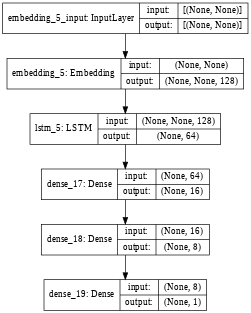

In [157]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [158]:
# Train
history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
875/875 [==============================] - 176s 198ms/step - loss: -483.4786 - accuracy: 0.0046 - val_loss: -6938.3525 - val_accuracy: 0.0643
Epoch 2/10
875/875 [==============================] - 173s 198ms/step - loss: -13653.6077 - accuracy: 0.0878 - val_loss: -44358.0156 - val_accuracy: 0.0858
Epoch 3/10
875/875 [==============================] - 173s 198ms/step - loss: -60917.8811 - accuracy: 0.0946 - val_loss: -126739.9688 - val_accuracy: 0.1263
Epoch 4/10
875/875 [==============================] - 172s 197ms/step - loss: -156492.2592 - accuracy: 0.1079 - val_loss: -224374.9531 - val_accuracy: 0.1927
Epoch 5/10
875/875 [==============================] - 172s 197ms/step - loss: -307517.3898 - accuracy: 0.1321 - val_loss: -461709.4062 - val_accuracy: 0.1256
Epoch 6/10
875/875 [==============================] - 172s 197ms/step - loss: -522116.6599 - accuracy: 0.1332 - val_loss: -720214.3750 - val_accuracy: 0.1445
Epoch 7/10
875/875 [==============================] - 171s 1

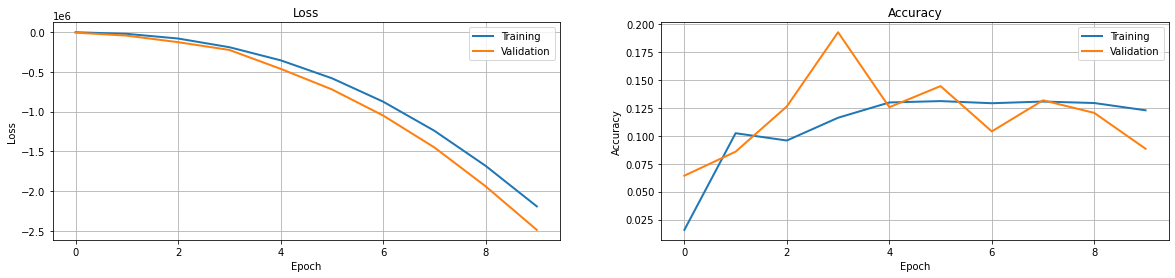

In [161]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [160]:
#checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model2.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[checkpoint2])

## Nuestro

In [317]:
model3 = Sequential()
model3.add(Embedding(max_words, 40, input_length=max_len))
model3.add(Bidirectional(layers.LSTM(20,dropout=0.6)))
model3.add(Dense(16,activation='relu'))
model3.add(Dense(1,activation='tanh'))

model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 40)           200000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_32 (Dense)             (None, 16)                656       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 210,433
Trainable params: 210,433
Non-trainable params: 0
_________________________________________________________________


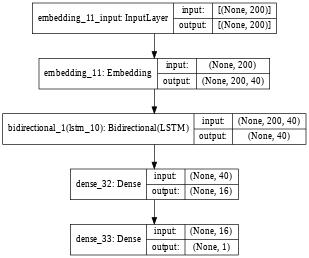

In [318]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True,
                          rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
%%timeit
# Train
history = model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
875/875 [==============================] - 110s 122ms/step - loss: 2.3718e-07 - accuracy: 0.5026 - val_loss: 2.4172e-07 - val_accuracy: 0.4931
Epoch 2/10
786/875 [=========================>....] - ETA: 10s - loss: 2.3710e-07 - accuracy: 0.5028

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Probamos

In [ ]:
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

## De la clase

In [ ]:
# Predict on test set
y_test_hat = tf.round(tf.sigmoid(model.predict(x_test)))

# Print a few examples of indices where label equals True
for ind in range(10):
  print("True:", np.where(y_test[ind] == 1.))
  print("Pred:", np.where(y_test_hat[ind] == 1.), "\n")

# Print a few examples of whole vectors
print("Test ground-truth:")
print(y_test[:5])
print("\n Test prediction:")
print(y_test_hat[:5])

In [ ]:
# Get embeddings
embeddings = np.copy(model.layers[0].get_weights()[0])

print(embeddings.shape)
print(embeddings.min())
print(embeddings.max())

In [ ]:
#
embeddings -= embeddings.min()
embeddings /= embeddings.max()

# Plot embeddings
plt.figure(figsize=(12, 4))
plt.imshow(embeddings[:80], cmap='jet')
plt.title('Primeros 80 embeddings (1000 -> 64)')
plt.colorbar()
plt.tight_layout()
plt.show()

## Nuestro

In [ ]:
sentiment = ['Neutral','Negative','Positive']
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]